## In this notebook: breast cancer diagnosis using support vector machine

In [1]:
import sys

# Matrix operations
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Data handling
import pandas as pd

# Support vector machine model
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# SMOTE sampling
import imblearn
from imblearn.over_sampling import SMOTE

# PCA for visualization purposes
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# deep learning
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from IPython.display import Image
from keras.utils.np_utils import to_categorical


Using TensorFlow backend.


### Data visualization

In [2]:
filepath = "breast-cancer-wisconsin-original.csv"
attributes = ['id','diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean',
              'compactness_mean','concavity_mean','concave_points_mean','symmetry_mean','fractal_dimension_mean',
              'radius_se','texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se',
              'concave points_se','symmetry_se','fractal_dimension_se','radius_worst','texture_worst',
              'perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst','concave_points_worst',
              'symmetry_worst','fractal_dimension_worst']

df = pd.read_csv(
    filepath_or_buffer = filepath,
    names = attributes)

df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### There is relatively a small amount of data so we will see how well the models perform

In [3]:
print(df.shape)

(569, 32)


In [4]:
df.drop(
    labels = ['id'],
    axis = 1,
    inplace = True)

df['diagnosis'] = pd.get_dummies(df['diagnosis'])

df.head(3)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


### Slight imbalance of the data so we will oversample by using SMOTE

In [5]:
df.groupby('diagnosis').count()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,,,,,,,,,,,,,,,,,,,,,
0,212,212,212,212,212,212,212,212,212,212,...,212,212,212,212,212,212,212,212,212,212
1,357,357,357,357,357,357,357,357,357,357,...,357,357,357,357,357,357,357,357,357,357


### Because SVM is distance based, we need to normalize the data

In [6]:
y = np.array(df['diagnosis'])
df = np.array(df.drop(['diagnosis'], 1))

scaler = MinMaxScaler(
    copy=True,
    feature_range=(0, 1))

scaler.fit(df)
df = scaler.transform(df)

scaler = StandardScaler()
scaler.fit(df)
df = scaler.transform(df)

In [7]:
df

array([[ 1.09706398, -2.07333501,  1.26993369, ...,  2.29607613,
         2.75062224,  1.93701461],
       [ 1.82982061, -0.35363241,  1.68595471, ...,  1.0870843 ,
        -0.24388967,  0.28118999],
       [ 1.57988811,  0.45618695,  1.56650313, ...,  1.95500035,
         1.152255  ,  0.20139121],
       ...,
       [ 0.70228425,  2.0455738 ,  0.67267578, ...,  0.41406869,
        -1.10454895, -0.31840916],
       [ 1.83834103,  2.33645719,  1.98252415, ...,  2.28998549,
         1.91908301,  2.21963528],
       [-1.80840125,  1.22179204, -1.81438851, ..., -1.74506282,
        -0.04813821, -0.75120669]])

### Oversample with SMOTE

In [8]:
X = np.array(df)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X,
    y,
    test_size = 0.2)

sm = SMOTE(
    sampling_strategy='not majority',
    k_neighbors = 5,
    n_jobs = 1,
    random_state = 12,
    ratio = 1.0)

X_res, y_res = sm.fit_sample(
    X_train,
    y_train)

In [9]:
print('X_train length: ' + str(len(X_train)))
print('X_test length: ' + str(len(X_test)))
print('X_res length: ' + str(len(X_res)))

X_train length: 455
X_test length: 114
X_res length: 566


## Support Vector Machine 
Use grid search to find the best kernel and value of C

In [10]:
clf = SVC(gamma = 'auto')

parameters = {
    'kernel':('linear', 'rbf'),
    'C':[0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

clf = GridSearchCV(
    clf, parameters,
    cv = 10,
    return_train_score = True,
    iid = False)

clf.fit(
    X_train,
    y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [11]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'split5_test_score',
 'split5_train_score',
 'split6_test_score',
 'split6_train_score',
 'split7_test_score',
 'split7_train_score',
 'split8_test_score',
 'split8_train_score',
 'split9_test_score',
 'split9_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [12]:
print(clf.cv_results_)

{'mean_fit_time': array([0.00266469, 0.00385921, 0.0014585 , 0.00250063, 0.00164752,
       0.00232885, 0.00188181, 0.00274677, 0.00246017, 0.00243735,
       0.0031487 , 0.00213606, 0.00628746, 0.00217314, 0.00666907,
       0.00360281]), 'std_fit_time': array([2.31931707e-03, 2.76548287e-04, 7.15740516e-05, 8.54709956e-05,
       1.34197845e-04, 2.38335987e-04, 2.49749179e-04, 7.61229355e-04,
       6.39827804e-04, 3.21191117e-04, 1.42011803e-03, 1.47013391e-04,
       3.21139569e-03, 1.19261053e-04, 3.33216357e-03, 9.07086983e-04]), 'mean_score_time': array([0.00071001, 0.00054915, 0.00023789, 0.00039515, 0.00024767,
       0.00044422, 0.00023642, 0.00050933, 0.00030355, 0.00043864,
       0.00031097, 0.00032628, 0.00023894, 0.00031388, 0.00034239,
       0.00073693]), 'std_score_time': array([1.17765285e-03, 8.96896376e-05, 4.92875273e-06, 1.02032010e-05,
       2.10478644e-05, 1.41364076e-04, 1.33204100e-05, 1.90322790e-04,
       4.29338574e-05, 8.56415200e-05, 6.84469014e-05, 1.

In [13]:
clf.best_estimator_

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
optimized_svm = clf.best_estimator_

optimized_svm.fit(
    X_train,
    y_train)

cv_results = model_selection.cross_val_score(
    optimized_svm,
    X_train,
    y_train,
    cv = 10,
    scoring='accuracy')

prediction_svm = optimized_svm.predict(X_test)

print('Test accuracy: ' + str(accuracy_score(y_test,prediction_svm)))
print('')
print('')
print(classification_report(
    y_test,
    prediction_svm))

Test accuracy: 0.956140350877193


              precision    recall  f1-score   support

           0       0.95      0.93      0.94        40
           1       0.96      0.97      0.97        74

   micro avg       0.96      0.96      0.96       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



### Rerun model with upsampled data to see if accuracy improves

In [15]:
clf = SVC(gamma = 'auto')

parameters = {
    'kernel':('linear', 'rbf'),
    'C':[0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

clf = GridSearchCV(
    clf, parameters,
    cv = 10,
    return_train_score = True,
    iid = False)

clf.fit(
    X_res,
    y_res)

optimized_svm = clf.best_estimator_

optimized_svm.fit(
    X_res,
    y_res)

cv_results = model_selection.cross_val_score(
    optimized_svm,
    X_train,
    y_train,
    cv = 10,
    scoring='accuracy')

clf.best_params_

{'C': 0.5, 'kernel': 'linear'}

In [16]:
prediction_svm = optimized_svm.predict(X_test)

print('Test accuracy: ' + str(accuracy_score(y_test,prediction_svm)))
print('')
print('')
print(classification_report(
    y_test,
    prediction_svm))

Test accuracy: 0.956140350877193


              precision    recall  f1-score   support

           0       0.93      0.95      0.94        40
           1       0.97      0.96      0.97        74

   micro avg       0.96      0.96      0.96       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



## To visualize the hyperplanes, use PCA to reduce to 2 dimensions

In [17]:
pca = PCA(n_components = 2)

In [18]:
principalComponents = pca.fit_transform(X_train)

In [19]:
optimized_svm.fit(
    principalComponents,
    y_train)

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Plot the decision boundary from grid search

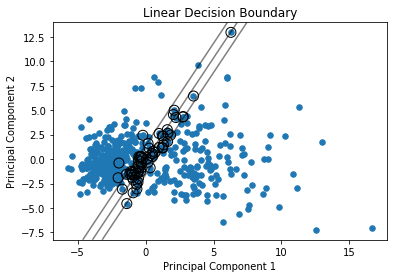

In [20]:
plt.scatter(principalComponents[:, 0],
            principalComponents[:, 1],
            s = 30,
            cmap = plt.cm.Paired)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(
    start = xlim[0],
    stop = xlim[1],
    num = 30)

yy = np.linspace(
    start = ylim[0],
    stop = ylim[1],
    num = 30)

YY, XX = np.meshgrid(
    yy,
    xx)

xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = clf.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['-', '-', '-'])

ax.scatter(optimized_svm.support_vectors_[:, 0], optimized_svm.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.title('Linear Decision Boundary')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## Out of curiousity, the radial basis function boundary is plotted below

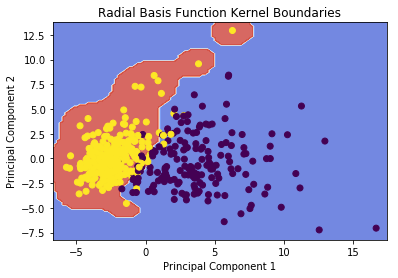

In [21]:
import matplotlib.pyplot as plt

clf = SVC(
    gamma = 'auto',
    C = 1.0,
    kernel = 'rbf')

clf.fit(principalComponents,
        y_train)

h = 0.2
x_min, x_max = principalComponents[:,0].min() - 1, principalComponents[:, 0].max() + 1
y_min, y_max = principalComponents[:,1].min() - 1, principalComponents[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h))

Z = clf.predict(
    np.c_[xx.ravel(),
          yy.ravel()])

Z = Z.reshape(xx.shape)

plt.contourf(
    xx,
    yy,
    Z,
    cmap = plt.cm.coolwarm,
    alpha = 0.8)

plt.scatter(
    principalComponents[:,0],
    principalComponents[:,1],
    c = y_train)

plt.title('Radial Basis Function Kernel Boundaries')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## Deep learning

In [22]:
seed = 15

# split for train, test
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X,
    y,
    test_size=0.3,
    random_state = seed,
    shuffle = True)

Y_train = to_categorical(y_train,
                         num_classes = None)

Y_test = to_categorical(y_test,
                        num_classes = None)

# split for train, validation
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(
    X_train,
    Y_train,
    test_size=0.3,
    random_state = seed,
    shuffle = True)

# Upsampling
sm = SMOTE(
    sampling_strategy='not majority',
    k_neighbors = 10,
    n_jobs = 1,
    random_state = 12,
    ratio = 0.7)

X_res, Y_res = sm.fit_sample(X_train, Y_train)

Y_res = to_categorical(Y_res,
                        num_classes = None)


In [23]:
input_layer = Input(shape=(30,))

x = Dense(
    units = 96,
    kernel_initializer='glorot_uniform',
    use_bias = True,
    bias_initializer='zeros')(input_layer)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

skip1 = x

x = Dense(
    units = 96,
    kernel_initializer='glorot_uniform',
    use_bias = True,
    bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([x, skip1])
x = Activation('relu')(x)

skip2 = x 

x = Dropout(rate = 0.3)(x)

x = Dense(
    units = 96,
    kernel_initializer='glorot_uniform',
    use_bias = True,
    bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([x, skip2])
x = Activation('relu')(x)

x = Dropout(rate = 0.3)(x)

x = Dense(
    units = 96,
    kernel_initializer='glorot_uniform',
    use_bias = True,
    bias_initializer='zeros')(input_layer)
x = BatchNormalization()(x)
x = keras.layers.Add()([x, skip1])
x = keras.layers.Add()([x, skip2])
x = Activation('relu')(x)

x = Dropout(rate = 0.3)(x)

y = Dense(
    units = 2,
    activation='softmax')(x)

model = Model(
    inputs = input_layer,
    outputs = y)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 96)           2976        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96)           384         dense_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96)           0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dense_2 (D

### Model performed on oversampled data

In [24]:
opt = SGD(lr= 2e-4)

model.compile(
    loss = "categorical_crossentropy",
    optimizer = opt,
    metrics = ['accuracy'])

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 5, 
    min_lr = 5e-7,
    verbose = 1)

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1,
    restore_best_weights = True)

history = model.fit(
    X_res,
    Y_res,                   
    epochs = 300, 
    batch_size = 4,
    verbose = 1,
    validation_data = (X_val, Y_val),
    callbacks = [reduce_lr,
                early_stopping])

Train on 302 samples, validate on 120 samples
Epoch 1/300
302/302 [==============================] - 1s 4ms/step - loss: 1.1304 - acc: 0.4139 - val_loss: 0.8882 - val_acc: 0.4417
Epoch 2/300
302/302 [==============================] - 0s 846us/step - loss: 0.9735 - acc: 0.4570 - val_loss: 0.7561 - val_acc: 0.5167
Epoch 3/300
302/302 [==============================] - 0s 835us/step - loss: 0.8573 - acc: 0.5000 - val_loss: 0.6351 - val_acc: 0.6667
Epoch 4/300
302/302 [==============================] - 0s 878us/step - loss: 0.7874 - acc: 0.5397 - val_loss: 0.5587 - val_acc: 0.7417
Epoch 5/300
302/302 [==============================] - 0s 546us/step - loss: 0.6264 - acc: 0.6623 - val_loss: 0.4916 - val_acc: 0.8167
Epoch 6/300
302/302 [==============================] - 0s 574us/step - loss: 0.6330 - acc: 0.6722 - val_loss: 0.4444 - val_acc: 0.8417
Epoch 7/300
302/302 [==============================] - 0s 482us/step - loss: 0.5811 - acc: 0.6887 - val_loss: 0.4090 - val_acc: 0.8750
Epoch 8/300

302/302 [==============================] - 0s 664us/step - loss: 0.3115 - acc: 0.8642 - val_loss: 0.1751 - val_acc: 0.9333
Epoch 61/300
302/302 [==============================] - 0s 604us/step - loss: 0.3557 - acc: 0.8642 - val_loss: 0.1739 - val_acc: 0.9333
Epoch 62/300
302/302 [==============================] - 0s 617us/step - loss: 0.3236 - acc: 0.8609 - val_loss: 0.1744 - val_acc: 0.9333
Epoch 63/300
302/302 [==============================] - 0s 659us/step - loss: 0.3034 - acc: 0.8775 - val_loss: 0.1724 - val_acc: 0.9417
Epoch 64/300
302/302 [==============================] - 0s 599us/step - loss: 0.3854 - acc: 0.8344 - val_loss: 0.1750 - val_acc: 0.9333

Epoch 00064: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 65/300
302/302 [==============================] - 0s 599us/step - loss: 0.3676 - acc: 0.8576 - val_loss: 0.1728 - val_acc: 0.9333
Epoch 66/300
302/302 [==============================] - 0s 877us/step - loss: 0.3763 - acc: 0.8411 - val_loss: 0.173

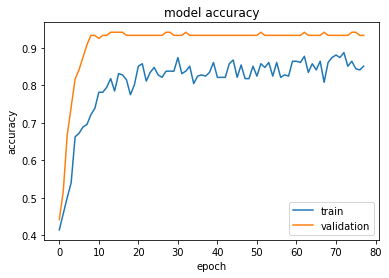

In [25]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

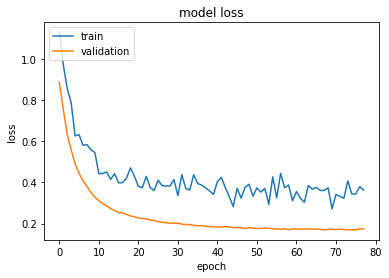

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
predictions = model.predict(X_test)
print('Test accuracy: ' + str(accuracy_score(np.argmax(Y_test, axis=1),np.argmax(predictions, axis=1))))
print('')
print('')
print(classification_report(np.argmax(Y_test, axis=1),np.argmax(predictions, axis=1)))

Test accuracy: 0.9532163742690059


              precision    recall  f1-score   support

           0       0.98      0.89      0.93        63
           1       0.94      0.99      0.96       108

   micro avg       0.95      0.95      0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171



In [28]:
del model

## Model performed on non-oversampled data

In [29]:
input_layer = Input(shape=(30,))

x = Dense(
    units = 96,
    kernel_initializer='glorot_uniform',
    use_bias = True,
    bias_initializer='zeros')(input_layer)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

skip1 = x

x = Dense(
    units = 96,
    kernel_initializer='glorot_uniform',
    use_bias = True,
    bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([x, skip1])
x = Activation('relu')(x)

skip2 = x 

x = Dropout(rate = 0.3)(x)

x = Dense(
    units = 96,
    kernel_initializer='glorot_uniform',
    use_bias = True,
    bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([x, skip2])
x = Activation('relu')(x)

x = Dropout(rate = 0.3)(x)

x = Dense(
    units = 96,
    kernel_initializer='glorot_uniform',
    use_bias = True,
    bias_initializer='zeros')(input_layer)
x = BatchNormalization()(x)
x = keras.layers.Add()([x, skip1])
x = keras.layers.Add()([x, skip2])
x = Activation('relu')(x)

x = Dropout(rate = 0.3)(x)

y = Dense(
    units = 2,
    activation='softmax')(x)

model = Model(
    inputs = input_layer,
    outputs = y)

model.summary()

opt = SGD(lr= 2e-4)

model.compile(
    loss = "categorical_crossentropy",
    optimizer = opt,
    metrics = ['accuracy'])

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 5, 
    min_lr = 5e-7,
    verbose = 1)

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1,
    restore_best_weights = True)

history = model.fit(
    X_res,
    Y_res,                   
    epochs = 300, 
    batch_size = 4,
    verbose = 1,
    validation_data = (X_val, Y_val),
    callbacks = [reduce_lr,
                early_stopping])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 96)           2976        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 96)           384         dense_6[0][0]                    
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 96)           0           batch_normalization_5[0][0]      
__________________________________________________________________________________________________
dense_7 (D

302/302 [==============================] - 0s 759us/step - loss: 0.3692 - acc: 0.8278 - val_loss: 0.2462 - val_acc: 0.9083
Epoch 34/300
302/302 [==============================] - 0s 577us/step - loss: 0.4066 - acc: 0.8146 - val_loss: 0.2409 - val_acc: 0.9083
Epoch 35/300
302/302 [==============================] - 0s 535us/step - loss: 0.3626 - acc: 0.8576 - val_loss: 0.2390 - val_acc: 0.9083
Epoch 36/300
302/302 [==============================] - 0s 574us/step - loss: 0.3565 - acc: 0.8477 - val_loss: 0.2379 - val_acc: 0.9083
Epoch 37/300
302/302 [==============================] - 0s 596us/step - loss: 0.3575 - acc: 0.8411 - val_loss: 0.2326 - val_acc: 0.9083
Epoch 38/300
302/302 [==============================] - 0s 932us/step - loss: 0.4140 - acc: 0.8344 - val_loss: 0.2294 - val_acc: 0.9083
Epoch 39/300
302/302 [==============================] - 0s 719us/step - loss: 0.3456 - acc: 0.8576 - val_loss: 0.2266 - val_acc: 0.9083
Epoch 40/300
302/302 [==============================] - 0s 55

Epoch 93/300
302/302 [==============================] - 0s 600us/step - loss: 0.3477 - acc: 0.8510 - val_loss: 0.1748 - val_acc: 0.9417
Epoch 94/300
302/302 [==============================] - 0s 479us/step - loss: 0.3695 - acc: 0.8477 - val_loss: 0.1759 - val_acc: 0.9333
Epoch 95/300
302/302 [==============================] - 0s 496us/step - loss: 0.2915 - acc: 0.8874 - val_loss: 0.1736 - val_acc: 0.9417
Epoch 96/300
302/302 [==============================] - 0s 585us/step - loss: 0.3076 - acc: 0.8609 - val_loss: 0.1727 - val_acc: 0.9417
Epoch 97/300
302/302 [==============================] - 0s 522us/step - loss: 0.3450 - acc: 0.8576 - val_loss: 0.1746 - val_acc: 0.9333
Epoch 98/300
302/302 [==============================] - 0s 495us/step - loss: 0.3376 - acc: 0.8609 - val_loss: 0.1738 - val_acc: 0.9417
Epoch 99/300
302/302 [==============================] - 0s 493us/step - loss: 0.3515 - acc: 0.8576 - val_loss: 0.1771 - val_acc: 0.9333
Epoch 100/300
302/302 [=========================

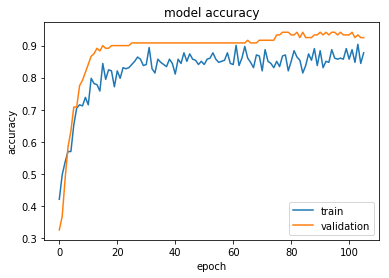

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

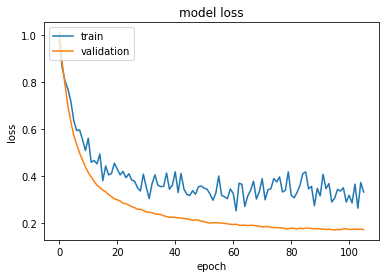

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [32]:
predictions = model.predict(X_test)
print('Test accuracy: ' + str(accuracy_score(np.argmax(Y_test, axis=1),np.argmax(predictions, axis=1))))
print('')
print('')
print(classification_report(np.argmax(Y_test, axis=1),np.argmax(predictions, axis=1)))

Test accuracy: 0.935672514619883


              precision    recall  f1-score   support

           0       0.98      0.84      0.91        63
           1       0.91      0.99      0.95       108

   micro avg       0.94      0.94      0.94       171
   macro avg       0.95      0.92      0.93       171
weighted avg       0.94      0.94      0.93       171



In [33]:
del model